# Taxi
The Taxi Problem involves navigating to passengers in a grid world, picking them up and 
dropping them off at one of four locations.

- The environment is a 5x5 grid world
- There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue)
- The taxi starts off at a random square and the passenger at one of the designated locations
- The goal is to:
    1. move the taxi to the passenger's location
    2. pick up the passenger
    3. move to the passenger’s desired destination
    4. drop off the passenger
- Once the passenger is dropped off, the episode ends
- The player receives positive rewards for successfully dropping-off the passenger at 
the correct location
- Negative rewards for incorrect attempts to pick-up/drop-off passenger
- Negative rewards for each step where another reward is not received.

## Action Space
- 0: Move south (down)
- 1: Move north (up)
- 2: Move east (right)
- 3: Move west (left)
- 4: Pickup passenger
- 5: Drop off passenger

## Observation Space
- There are 500 discrete states:
    - 25 taxi positions
    - 5 possible locations of the passenger
        - 0: Red
        - 1: Green
        - 2: Yellow
        - 3: Blue
        - 4: In taxi
    - 4 destination locations
        - 0: Red
        - 1: Green
        - 2: Yellow
        - 3: Blue
- An observation is returned as an int() that encodes the corresponding state:
    - `((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination`

## Rewards
- -1 per step unless other reward is triggered
- +20 delivering passenger.
- -10 executing “pickup” and “drop-off” actions illegally.

https://gymnasium.farama.org/environments/toy_text/taxi/

Observation Space Discrete(500)
Action Space Shape 6


<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


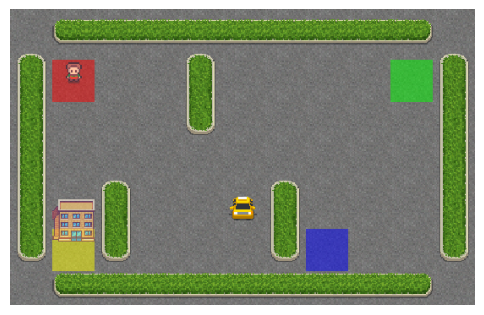

In [1]:
from datetime import datetime
from typing import NamedTuple

import gymnasium as gym
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm

from r2seedo.models.q_table import QTable, train_for_one_episode

env = gym.make(id="Taxi-v3", render_mode="rgb_array")


print("Observation Space", env.observation_space)
print("Action Space Shape", env.action_space.n)

_ = env.reset()
frame = env.render()

_, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(frame)
ax.axis("off");

## Initialize Q-Table Agent

In [2]:
agent = QTable(
    num_states=env.observation_space.n,
    num_actions=env.action_space.n,
    discount_factor=0.95,
    action_names=["S", "N", "E", "W", "Pup", "Doff"],
)

print(agent)
print(agent.to_dataframe().head())

QTable(num_states=500, num_actions=6, discount_factor=0.95)
     S    N    E    W  Pup  Doff
0  0.0  0.0  0.0  0.0  0.0   0.0
1  0.0  0.0  0.0  0.0  0.0   0.0
2  0.0  0.0  0.0  0.0  0.0   0.0
3  0.0  0.0  0.0  0.0  0.0   0.0
4  0.0  0.0  0.0  0.0  0.0   0.0


In [3]:
train_for_one_episode(agent, env, 10, 0.1, 1, verbose=True)

0: state=108, action= 5, reward= -10, total_reward=  -10
1: state=108, action= 3, reward=  -1, total_reward=  -11
2: state=108, action= 4, reward= -10, total_reward=  -21
3: state=108, action= 4, reward= -10, total_reward=  -31
4: state=108, action= 3, reward=  -1, total_reward=  -32
5: state=108, action= 5, reward= -10, total_reward=  -42
6: state=208, action= 0, reward=  -1, total_reward=  -43
7: state=208, action= 3, reward=  -1, total_reward=  -44
8: state=228, action= 2, reward=  -1, total_reward=  -45
9: state=228, action= 5, reward= -10, total_reward=  -55


-55.0

# Train agent

In [4]:
def train(
    agent: QTable,
    env: gym.Env,
    num_episodes: int,
    max_steps: int,
    learning_rate: float,
    max_epsilon: float,
    min_epsilon: float,
    decay_rate: float,
) -> list[float]:
    """Train a Q-table agent in an environment for a specified number of episodes."""
    # Define exploration rate schedule
    epsilon_schedule = min_epsilon + (max_epsilon - min_epsilon) * np.exp(
        -decay_rate * np.arange(num_episodes)
    )

    episode_rewards = [
        train_for_one_episode(agent, env, max_steps, learning_rate, epsilon)
        for epsilon in tqdm(epsilon_schedule)
    ]

    return episode_rewards

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [00:16<00:00, 1783.78it/s]


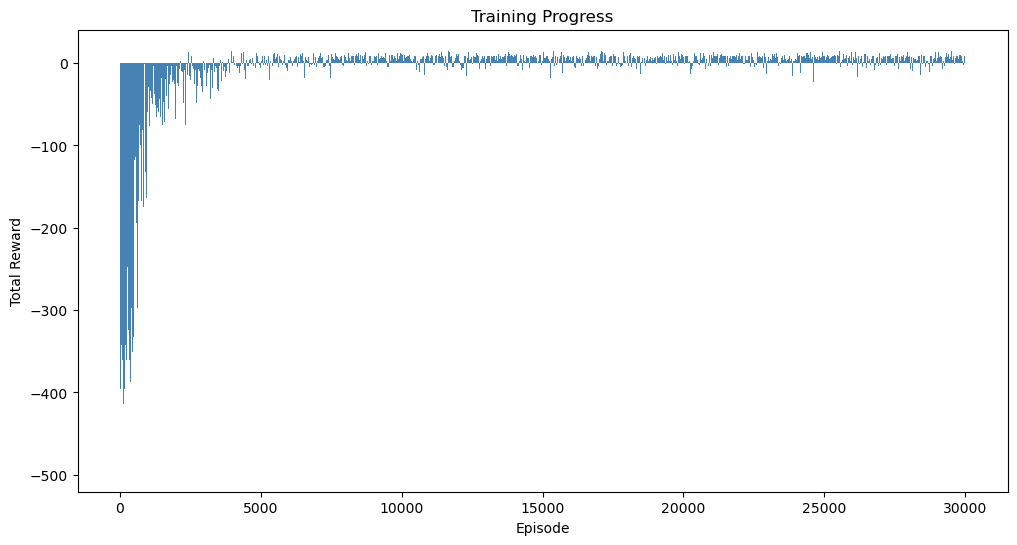

In [5]:
training_progress = train(
    agent,
    env,
    num_episodes=30_000,
    max_steps=99,
    learning_rate=0.7,
    max_epsilon=1,
    min_epsilon=0.05,
    decay_rate=0.0005,
)

_, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(
    x=np.arange(len(training_progress)),
    height=training_progress,
    width=1.0,
    color="steelblue",
)
ax.set_xlabel("Episode")
ax.set_ylabel("Total Reward")
ax.set_title("Training Progress");

# Evaluate Agent

In [6]:
class EvalResult(NamedTuple):
    """Summary of total rewards over evaluation episodes."""

    env_id: str
    map_name: str
    num_episodes: int
    mean_reward: float
    std_reward: float
    eval_datetime: str = datetime.now().isoformat()


def evaluate(
    agent: QTable,
    env: gym.Env,
    num_episodes: int,
    max_steps: int,
    seeds: list[int] | None = None,
) -> EvalResult:
    """Evaluate the agent in the environment for a number of episodes."""
    total_rewards = []
    if seeds is None:
        seeds = np.random.randint(0, 2**32, size=num_episodes)
    else:
        seeds = np.array(seeds)
        if len(seeds) != num_episodes:
            raise ValueError("Number of seeds != number of episodes.")

    for seed in tqdm(seeds.astype(int).tolist()):
        state, _ = env.reset(seed=seed)
        state = torch.tensor(state)
        total_reward = 0
        for _ in range(max_steps):
            action = agent.get_action(state, epsilon=0)
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            next_state = torch.tensor(next_state)
            state = next_state
            total_reward += reward
            if terminated or truncated:
                break
        total_rewards.append(total_reward)

    return EvalResult(
        env_id=env.spec.id,
        map_name=env.spec.kwargs.get("map_name"),
        num_episodes=num_episodes,
        mean_reward=np.mean(total_rewards),
        std_reward=np.std(total_rewards),
    )

In [7]:
eval_results = evaluate(
    agent,
    env,
    num_episodes=100,
    max_steps=99,
    seeds=[
        16,
        54,
        165,
        177,
        191,
        191,
        120,
        80,
        149,
        178,
        48,
        38,
        6,
        125,
        174,
        73,
        50,
        172,
        100,
        148,
        146,
        6,
        25,
        40,
        68,
        148,
        49,
        167,
        9,
        97,
        164,
        176,
        61,
        7,
        54,
        55,
        161,
        131,
        184,
        51,
        170,
        12,
        120,
        113,
        95,
        126,
        51,
        98,
        36,
        135,
        54,
        82,
        45,
        95,
        89,
        59,
        95,
        124,
        9,
        113,
        58,
        85,
        51,
        134,
        121,
        169,
        105,
        21,
        30,
        11,
        50,
        65,
        12,
        43,
        82,
        145,
        152,
        97,
        106,
        55,
        31,
        85,
        38,
        112,
        102,
        168,
        123,
        97,
        21,
        83,
        158,
        26,
        80,
        63,
        5,
        81,
        32,
        11,
        28,
        148,
    ],
)
eval_results._asdict()

100%|██████████| 100/100 [00:00<00:00, 3714.01it/s]


{'env_id': 'Taxi-v3',
 'map_name': None,
 'num_episodes': 100,
 'mean_reward': 7.56,
 'std_reward': 2.706732347314747,
 'eval_datetime': '2024-04-19T10:09:35.946261'}